Nombres:
* Óscar Calvet Sisó
* Enrique Ernesto de Alvear Doñate

# GridWorld 2:

*GridWorld* es un mundo en forma de cuadrícula muy utilizado como entorno de pruebas para técnicas de Aprendizaje por Refuerzo. Dentro de esta cuadrícula hay varios tipos de celdas: iniciales, libres, obstáculos, terminales... ¡y ahora también agujeros de gusano! Los agentes tienen que llegar desde una celda inicial hasta otra terminal evitando los obtáculos y recorriendo una distancia mínima.

Paquetes necesarios para *GridWorld 2*:

In [ ]:
import numpy as np
import math
from matplotlib import pyplot as plt

Funciones auxiliares para visualizar información:

In [ ]:
def printMap(world):
  # Visualiza el mapa de GridWorld
  m = "["
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if world.map[(i, j)] == 0:
        m += " O "
      elif world.map[(i, j)] == -1:
        m += " X "
      elif world.map[(i, j)] == 1:
        m += " F "
      elif world.map[(i, j)] == 2:
        m += " T "
    if i == world.size[0] - 1:
      m += "]\n"
    else:
      m += "\n"
  print(m)

def printPolicy(world, policy):
  # Visualiza la política con flechas
  p = "["
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if policy[i][j] == 0:
        p += " ^ "
      elif policy[i][j] == 1:
        p += " V "
      elif policy[i][j] == 2:
        p += " < "
      elif policy[i][j] == 3:
        p += " > "
      else:
        p += " x "
    if i == world.size[0] - 1:
      p += "]\n"
    else:
      p += "\n"
  print(p)

# Clase *World*:

Esta clase almacena la información del mundo:

*   *Map*: Matriz con la codificación del mundo con celdas libres (0), obstáculos (-1) y terminales (1)
*   *Size*: Vector con el tamaño de la matriz de codificación del mundo (ancho, alto)

Para crear un mundo hay que aportar los siguientes datos:

*   Tamaño del mapa (ancho, alto)
*   Lista de celdas terminales
*   Lista de celdas con obstáculos
*   Agujero de gusano

Notas:

* Cuando el agente cae en un obstáculo se queda atrapado para siempre en él
* Cuando el agente entra por un extremo del agujero de gusano sale por el otro extremo

Por ejemplo:

w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])

Crea un mundo de 10 filas y 10 columnas con un estado terminal (9, 9), dos obstáculos en (2, 4) y (4, 2) y un teletransporte entre (0, 2) y (9, 7).

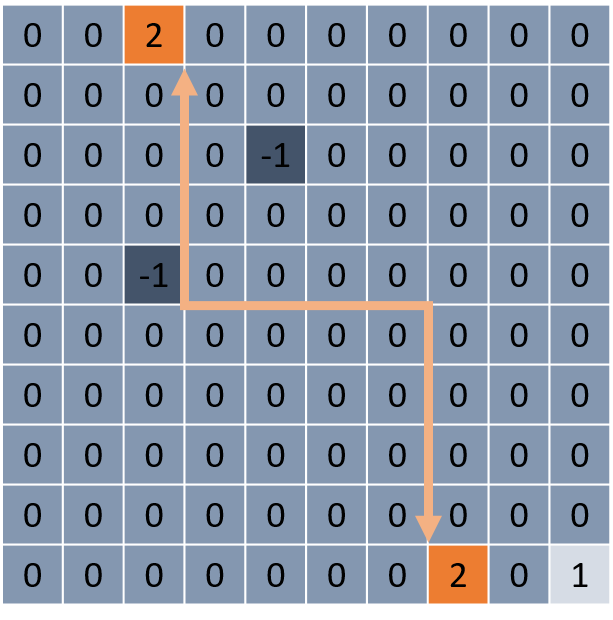

In [ ]:
class World:

  def __init__(self, size, terminal, obstacle, hole):
    # Crea un mundo
    self.size = size
    self.map = {}
    for i in range(size[0]):
      for j in range(size[1]):
        # Estados libres
        self.map[(i, j)] = 0
        # Estados terminales
        for t in terminal:
          if i==t[0] and j==t[1]:
            self.map[(i, j)] = 1
        # Estados con obstáculos
        for o in obstacle:
          if i==o[0] and j==o[1]:
            self.map[(i, j)] = -1
        for h in hole:
          if i==h[0] and j==h[1]:
            self.map[(i, j)] = 2

Prueba de la clase *World*:

In [ ]:
if __name__ == "__main__":
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
  printMap(w)

[ O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F ]



# Clase *Agent*:

Esta clase controla el agente que aprende por refuerzo en *GridWorld*.

Para crear un agente se necesitan los siguientes datos:

*   *World*: Mundo en el que se desenvuelve el agente.
*   *Initial State*: Estado inicial del agente.

Para controlar el agente se usan los siguientes métodos:

*   *nextState = move(state, action)*: Mueve el agente del estado *state* a un nuevo estado *nextState* aplicando una acción *action*.
*   *reward = reward(nextState)*: Devuelve el refuerzo *reward* que recibe el agente al transicionar al estado *nextState*.
*   *nextState, reward = checkAction(state, action)*: Comprueba a qué estado *nextState* y con qué refuerzo *reward* cambia el agente al aplicar la acción *action* en el estado *state*. Este método no cambia el estado interno del agente, por lo que puede usarse para hacer barridos del espacio de estados.
*   *nextState, reward = executeAction(action)*: Ejecuta la acción *action* en el estado actual y devuelve el nuevo estado *nextState* y el refuerzo *reward*. Este método cambia el estado interno del agente, por lo que sólo debe usarse cuando se realice un recorrido por el mundo.

Nota: Podéis hacer cambios en el agente (distribución de refuerzos, comportamiento en obstáculos...) buscando mejorar el rendimiento de los algoritmos.

In [ ]:
class Agent:

  def __init__(self, world, initialState):
    # Crea un agente
    self.world = world
    self.state = np.array(initialState)

  def move(self, state, action):
    # Gestiona las transiciones de estados
    nextState = state + np.array(action)
    if nextState[0] < 0:
      nextState[0] = 0
    elif nextState[0] >= self.world.size[0]:
      nextState[0] = self.world.size[0] - 1
    if nextState[1] < 0:
      nextState[1] = 0
    elif nextState[1] >= self.world.size[1]:
      nextState[1] = self.world.size[1] - 1
    if self.world.map[(nextState[0], nextState[1])] == 2:
      aux = nextState
      for i in range(self.world.size[0]):
        for j in range(self.world.size[1]):
          if self.world.map[(i, j)] == 2 and (nextState[0] != i and nextState[1] != j):
            aux = np.array([i, j])
            nextState = aux
    elif self.world.map[(nextState[0], nextState[1])] == -1:
      nextState = self.state
    return nextState

  def reward(self, nextState):
    # Gestiona los refuerzos
    if self.world.map[(nextState[0], nextState[1])] == -1:
      # Refuerzo cuando el agente intenta moverse a un obstáculo
      reward = -1 # ** Prueba varios valores **
    elif self.world.map[(nextState[0], nextState[1])] == 1:
      # Refuerzo cuando el agente se mueve a una celda terminal
      reward = 100 # ** Prueba varios valores **
    elif (nextState[0] == self.state[0]) and (nextState[1] == self.state[1]):#Si se sale del mapa o se golpea contra una pared
      reward = -1
    else:
      # Refuerzo cuando el agente se mueve a una celda libre
      reward = -0.2 # ** Prueba varios valores **
    return reward

  def checkAction(self, state, action):
    # Planifica una acción
    nextState = self.move(state, action)
    if self.world.map[(state[0], state[1])] == -1:
      nextState = state
    reward = self.reward(nextState)
    return nextState, reward

  def executeAction(self, action):
    # Planifica y ejecuta una acción
    nextState = self.move(self.state, action)
    reward = self.reward(nextState)
    if self.world.map[(self.state[0], self.state[1])] == -1:
      nextState = self.state
    else:
      self.state = nextState
    return self.state, reward

Prueba de la clase *Agent*:

In [ ]:
if __name__ == "__main__":
  # Crear el mundo
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
  printMap(w)
  # Crear el agente
  a = Agent(w, (0, 0))
  # Mover el agente en la diagonal principal
  for i in range(1, 5):
    # Mostrar cada nuevo estado y su recompensa
    print(a.executeAction((0, 1)))

[ O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F ]

(array([0, 1]), -0.2)
(array([9, 7]), -0.2)
(array([9, 8]), -0.2)
(array([9, 9]), 100)


# Trabajo:

En este trabajo vais a implementar los dos algoritmos más comunes de aprendizaje por refuerzo basados en el valor: SARSA y QLearning. Además, vais a probar ambos algoritmos en una serie de escenarios para evaluar su funcionamiento y comparar sus resultados.

## Mundos:

Para probar los algoritmos se ofrecen los siguientes mundos en varios tamaños:

*   Mundo 1: Laberinto fácil que se puede recorrer en zigzag
*   Mundo 2: Mundo con obstáculos aleatorios en el que el teletransporte acorta la distancia desde el inicio hasta el final
*   Mundo 3: Mundo con obstáculos aleatorios en el que el teletransporte no reduce la distancia desde el inicio hasta el final
*   Mundo 4: Laberinto difícil con caminos correctos y equivocados

Nota: Sentíos libres de utilizar todos o algunos de estos escenarios o directamente crear vuestros propios escenarios.

In [ ]:
if __name__ == "__main__":

  # Mundo 1 pequeño: Laberinto fácil
  obstacles = []
  for j in range(0, 4):
    obstacles.append((j, 1))
  for j in range(1, 5):
    obstacles.append((j, 3))
  w1p = World((5, 5), [(4, 4)], obstacles, [])
  print("World 1: ")
  printMap(w1p)

  # Mundo 1 mediano: Laberinto fácil
  obstacles = []
  for i in [1, 5]:
    for j in range(0, 8):
      obstacles.append((j, i))
  for i in [3, 7]:
    for j in range(1, 9):
      obstacles.append((j, i))
  w1m = World((9, 9), [(8, 8)], obstacles, [])
  print("World 1: ")
  printMap(w1m)

  # Mundo 1 grande: Laberinto fácil
  obstacles = []
  for i in [1, 5, 9, 13, 17]:
    for j in range(0, 20):
      obstacles.append((j, i))
  for i in [3, 7, 11, 15, 19]:
    for j in range(1, 21):
      obstacles.append((j, i))
  w1g = World((21, 21), [(20, 20)], obstacles, [])
  print("World 1: ")
  printMap(w1g)

  # Mundo 2 pequeño: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))
  w2p = World((5, 5), [(4, 4)], obstacles, [(2, 0), (4, 2)])
  print("World 2: ")
  printMap(w2p)

  # Mundo 2 mediano: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))
  w2m = World((10, 10), [(9, 9)], obstacles, [(3, 1), (8, 6)])
  print("World 2: ")
  printMap(w2m)

  # Mundo 2 grande: Obstáculos aleatorios, teletransporte útil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))
  w2g = World((21, 21), [(20, 20)], obstacles, [(6, 2), (18, 14)])
  print("World 2: ")
  printMap(w2g)

  # Mundo 3 pequeño: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))
  w3p = World((5, 5), [(4, 4)], obstacles, [(4, 0), (0, 4)])
  print("World 3: ")
  printMap(w3p)

  # Mundo 3 mediano: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))
  w3m = World((10, 10), [(9, 9)], obstacles, [(8, 1), (1, 8)])
  print("World 3: ")
  printMap(w3m)

  # Mundo 3 grande: Obstáculos aleatorios, teletransporte inútil
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))
  w3g = World((21, 21), [(20, 20)], obstacles, [(18, 2), (2, 18)])
  print("World 3: ")
  printMap(w3g)

  # Mundo 4: Laberinto difícil
  obstacles = [(0,1),(0,3),(0,9),(0,15),(0,16),(0,17),(0,19),
               (1,1),(1,3),(1,4),(1,5),(1,6),(1,7),(1,9),(1,10),(1,11),(1,12),(1,13),(1,17),(1,19),
               (2,1),(2,9),(2,13),(2,15),(2,16),(2,17),(2,19),
               (3,1),(3,3),(3,5),(3,7),(3,9),(3,11),(3,16),(3,19),
               (4,3),(4,5),(4,7),(4,8),(4,9),(4,10),(4,11),(4,12),(4,13),(4,14),(4,16),(4,18),(4,19),
               (5,0),(5,1),(5,2),(5,3),(5,5),(5,9),(5,16),
               (6,5),(6,6),(6,7),(6,9),(6,10),(6,11),(6,12),(6,13),(6,14),(6,16),(6,17),(6,19),
               (7,0),(7,1),(7,2),(7,3),(7,5),(7,7),(7,9),(7,19),
               (8,3),(8,7),(8,8),(8,9),(8,12),(8,13),(8,14),(8,15),(8,16),(8,17),(8,18),(8,19),
               (9,1),(9,3),(9,5),(9,7),(9,11),(9,12),(9,19),(9,20),
               (10,1),(10,3),(10,5),(10,6),(10,7),(10,9),(10,11),(10,14),(10,15),(10,16),(10,17),
               (11,1),(11,3),(11,5),(11,9),(11,11),(11,13),(11,14),(11,17),(11,18),(11,19),
               (12,1),(12,5),(12,6),(12,8),(12,9),(12,11),(12,13),(12,19),
               (13,1),(13,2),(13,3),(13,4),(13,5),(13,8),(13,15),(13,16),(13,17),(13,19),
               (14,4),(14,7),(14,8),(14,10),(14,12),(14,13),(14,15),(14,19),
               (15,0),(15,1),(15,2),(15,6),(15,7),(15,10),(15,13),(15,14),(15,15),(15,17),(15,18),(15,19),(15,20),
               (16,2),(16,3),(16,5),(16,6),(16,7),(16,8),(16,9),(16,10),(16,11),(16,15),(16,17),
               (17,0),(17,3),(17,5),(17,9),(17,13),(17,14),(17,15),(17,17),(17,19),
               (18,0),(18,1),(18,5),(18,6),(18,7),(18,9),(18,10),(18,11),(18,15),(18,19),
               (19,1),(19,2),(19,4),(19,5),(19,11),(19,13),(19,14),(19,15),(19,16),(19,17),(19,18),(19,19),
               (20,7),(20,8),(20,9),(20,11),(20,19)]
  print("World 4: ")
  w4 = World((21, 21), [(20, 20)], obstacles, [])
  printMap(w4)

World 1: 
[ O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

World 1: 
[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

World 1: 
[ O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  

## SARSA:

*SARSA* (State-Action-Reward-State-Action) es un método basado en el valor que permite resolver problemas de aprendizaje por refuerzo. Al igual que el resto de métodos basados en el valor, *SARSA* calcula de forma iterativa la función de valor $Q(S,A)$ y, a partir de ella, determina la política óptima $\pi$.

*SARSA* recibe su nombre de las cinco variables implicadas en su función de actualización: el estado actual ($S_t$), la acción actual ($A_t$), el refuerzo actual ($R_t$), el siguiente estado ($S_{t+1}$) y la siguiente acción ($A_{t+1}$). Esta función de actualización tiene la siguiente forma:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t,A_t)]
\end{equation}

Nota: $\alpha$ es la longitud del episodio y $\gamma$ el factor de descuento.

El algoritmo *SARSA* sigue el siguiente esquema:

1.   Inicializar $Q(S,A)$ para todos los estados y acciones
2.   **Bucle** (repetir $3-9$ hasta la convergencia):
3.   Inicializar $S_t$
4.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
5.   **Bucle** (repetir $6-9$ hasta que $S_t$ sea terminal):
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Elegir $A_{t+1}$ en $S_{t+1}$ siguiendo la política derivada de $Q(S,A)$
8.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
9.   Tomar $S_{t+1}$ y $A_{t+1}$ como los nuevos $S_t$ y $A_t$

El algoritmo *SARSA* utiliza un parámetro $\epsilon \in (0, 1)$ para buscar un equilibrio entre exploración y explotación. A la hora de elegir $A_t$ en $S_t$, si un número aleatorio es menor que $\epsilon$, el algoritmo tomará una acción aleatoria; mientras que si ese número aleatorio es mayor que $\epsilon$, el algoritmo tomará la mejor acción conocida.

## Ejercicio 1:

Implementad el algoritmo SARSA para el agente y entorno definidos anteriormente.

In [ ]:
# Resolución: Código de SARSA

def sarsa(mundo, inic, alpha, gamma, eps ,actions = [(-1,0), (0,-1), (1,0), (0,1)] ,max_epochs = 100, max_iters = 10000):
  agente = Agent(mundo, inic)
  Q = np.zeros([mundo.size[0], mundo.size[1], len(actions)])#Para diagonal poner 8
  for epoch in range(max_epochs):
    s = inic
    agente = Agent(mundo, inic)
    if np.random.rand() > eps:
      acc = np.argmax(Q[s[0], s[1], :])
    else:
      acc = np.random.randint(len(actions))
    i = 0
    #print('Accion ini:' + str(actions[acc]))
    while  (i < max_iters) and (mundo.map[s[0], s[1]] != 1):
      state, r = agente.executeAction(actions[acc])
      #print('Estado siguiente: ' + str(state) + ' con r: ' + str(r))
      if np.random.rand() > eps:
        acc_new = np.argmax(Q[state[0], state[1], :])
      else:
        acc_new = np.random.randint(len(actions))
      #print('Accion siguiente' + str(actions[acc_new]))
      Q[s[0], s[1], acc] += alpha * (r + gamma * Q[state[0], state[1], acc_new] - Q[s[0], s[1], acc])
      s = state
      acc = acc_new
      i+=1
  return Q


In [ ]:
Q = sarsa(w2m, [0,0], 0.95, 0.85, 0.1)
print(Q)

[[[-1.02538544e+00 -2.65667556e-01  1.22115353e+00 -9.48062205e-01]
  [-1.68188159e+00  1.17672058e+00  2.82831330e+01 -8.85838560e-01]
  [-1.66593244e+00 -9.22981767e-01  2.38268113e+01 -8.10441289e-01]
  [-9.97500000e-01 -8.14109016e-01 -7.92203636e-01 -7.33884280e-01]
  [-9.97500000e-01 -7.10740711e-01 -8.06506447e-01 -7.05038393e-01]
  [-1.28486194e+00 -7.09849448e-01 -7.93918641e-01 -6.17744772e-01]
  [-9.97500000e-01 -7.09171273e-01 -1.28486194e+00 -1.03273212e+00]
  [-1.28486194e+00 -7.29555271e-01 -3.68742500e-01 -4.92633188e-01]
  [-9.97500000e-01 -4.92633188e-01 -4.92633188e-01 -4.92633188e-01]
  [-9.97500000e-01 -4.92633188e-01 -4.92633188e-01 -1.15092500e+00]]

 [[-6.96064387e-01 -8.13610652e-01 -1.11309621e+00 -5.91198453e-01]
  [-8.16351192e-01 -7.15433866e-01  3.33363069e+00 -8.16630237e-01]
  [-6.76693802e-01 -8.66638769e-01  3.12108995e+01  1.15443205e-01]
  [-7.15725334e-01  1.83493064e-01 -7.37494377e-01 -7.20196197e-01]
  [-7.88247674e-01 -7.93559487e-01 -7.93784615

## Q-Learning:

*Q-Learning* es el método más conocido para resolver problemas de aprendizaje por refuerzo mediante un esquema basado en el valor. Este algoritmo recibe su nombre directamente de $Q(S,A)$, la función de valor que va actualizando a lo largo de su ejecución. *Q-Learning* es muy parecido a *SARSA*, pero tiene una función de actualización diferente:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma max_a{Q(S_{t+1}}, a) - Q(S_t,A_t)]
\end{equation}

En este caso, la acción $A_{t+1}$ en $S_{t+1}$ se toma buscando el máximo valor, en lugar de poder elegir entre exploración o explotación.

El algoritmo *Q-Learning* sigue el siguiente esquema:

1.   Inicializar $Q(S,A)$ para todos los estados y acciones
2.   **Bucle** (repetir $3-8$ hasta la convergencia):
3.   Inicializar $S_t$
4.   **Bucle** (repetir $6-8$ hasta que $S_t$ sea terminal):
5.   Elegir $A_t$ en $S_t$ siguiendo la política derivada de $Q(S,A)$
6.   Tomar la acción $A_t$ en $S_t$ y observar $R_t$ y $S_{t+1}$
7.   Actualizar el valor $Q(S_t, A_t)$ con la función de actualización
8.   Tomar $S_{t+1}$ como el nuevo $S_t$

## Ejercicio 2:
Implementad el algoritmo Q-Learning para el agente y entorno definidos anteriormente.


In [ ]:
# Resolución: Código de SARSA

def qlearn(mundo, inic, alpha, gamma, eps ,actions = [(-1,0), (0,-1), (1,0), (0,1)] ,max_epochs = 100, max_iters = 10000):
  agente = Agent(mundo, inic)
  Q = np.zeros([mundo.size[0], mundo.size[1], len(actions)])#Para diagonal poner 8
  for epoch in range(max_epochs):
    s = inic
    agente = Agent(mundo, inic)
    if np.random.rand() > eps:
      acc = np.argmax(Q[s[0], s[1], :])
    else:
      acc = np.random.randint(len(actions))
    i = 0
    #print('Accion ini:' + str(actions[acc]))
    while  (i < max_iters) and (mundo.map[s[0], s[1]] != 1):
      state, r = agente.executeAction(actions[acc])
      #print('Estado siguiente: ' + str(state) + ' con r: ' + str(r))
      if np.random.rand() > eps:
        acc_new = np.argmax(Q[state[0], state[1], :])
      else:
        acc_new = np.random.randint(len(actions))
      #print('Accion siguiente' + str(actions[acc_new]))
      Q[s[0], s[1], acc] += alpha * (r + gamma * np.max(Q[state[0], state[1], :]) - Q[s[0], s[1], acc])
      s = state
      acc = acc_new
      i+=1
  return Q

In [ ]:
Q = qlearn(w2m, [0,0], 0.95, 0.85, 0.1)
print(Q)

[[[ 25.4694002   24.15521288  31.15181161  21.9998744 ]
  [ -0.9975      -0.81534116  26.27487641  -0.73876864]
  [ -1.51238764  -0.72028605  -0.71516324  -0.72162753]
  [ -0.9975      -0.7088999   -0.71552472  -0.71547721]
  [ -0.9975      -0.7152425   -0.79814732  -0.71600839]
  [ -0.9975      -0.72353053  -0.72159562  -0.72029768]
  [ -0.95        -0.79786426  -1.28248694  -0.71546076]
  [ -0.95        -0.71999818  -0.62254231  -0.71519223]
  [ -0.95        -0.71481199  -0.70958441  -0.71567792]
  [ -1.49493031  -0.71670835  -0.71488347  -0.95      ]]

 [[ 24.92492894  28.78434603  36.88448425  24.87510273]
  [ 20.98771179  29.55804314  31.15151629  -0.70561706]
  [ -0.71458559  -0.62780375  -0.71007096  -0.70985202]
  [ -0.71516126  -0.7140609   -0.71998805  -0.73291346]
  [ -0.79437564  -0.79891567  -0.71516126  -0.72857676]
  [ -0.79896053  -0.71524259  -0.71594255  -1.150925  ]
  [  0.           0.           0.           0.        ]
  [ -0.70977065  -0.9975      -0.61332666  -0.

## Análisis:

*SARSA* y *Q-Learning* son dos algoritmos muy parecidos, que se pueden aplicar en los mismos problemas y suelen encontrar soluciones similares. No obstante, los resultados de ambos algoritmos pueden diferir en ciertos problemas: por ejemplo, hay un problema llamado Cliffworld en el que SARSA encuentra soluciones más seguras y con menos valor, mientras que Q-Learning asume más riesgos y consigue más valor ([artículo interesante](https://medium.com/gradientcrescent/fundamentals-of-reinforcement-learning-navigating-cliffworld-with-sarsa-and-q-learning-cc3c36eb5830)).

## Ejercicio 3:

Analizad los resultados obtenidos por ambos algoritmos en los escenarios de prueba. Algunos posibles análisis se muestran a continuación, no es necesario que hagáis todos.

1.   Comentad el rendimiento que observáis en ambos algoritmos. ¿Qué problemas son capaces de resolver? ¿En cuáles no encuentran la solución óptima? ¿A qué se puede deber este comportamiento?

2.   Comentad las diferencias entre los algoritmos en los diferentes escenarios: ¿Cuál resuelve más escenarios? ¿Cuál converge más rápido? ¿Cuál genera más valor?

Nota: Las siguientes variables pueden ser interesantes para valorar los resultados: Diferencia entre la política resultante y la política óptima, número de iteraciones necesarias para converger, retorno total del problema y retorno obtenido en cada episodio.

3.   Comentad las diferencias cuando se aplica una mayor exploración ($\epsilon$ más alto) y una mayor explotación ($\epsilon$ más bajo). ¿Cuál converge más rápido? ¿Cuál obtiene más valor? ¿Qué estrategia piensas que podría usarse para explorar y explotar de forma más inteligente?

4.   Comentad las diferencias cuando se varían otros parámetros como el número de episodios, el ratio de aprendizaje ($\alpha$) o el factor de descuento ($\gamma$). ¿Qué valores dan mejores resultados?

**Respuestas más abajo**

Comenzamos definiendo un grupo de funciones que nos ayudarán a representar el mundo y los recorridos del agente.

In [ ]:
def visualize_path(world, Q, ini, max_iter = 1000, actions = [(-1,0), (0,-1), (1,0), (0,1)]):
  i = 0
  total_rew = 0
  current = ini
  visitados = [(ini[0], ini[1])]
  agente = Agent(world, ini)
  repetido = False
  ciclo2 = [-1,-1]
  while (i < max_iter) and (world.map[current[0], current[1]] != 1) and (not repetido):
    m = gen_map(world, current, visitados)
    print(m)
    next = np.argmax(Q[current[0], current[1], :])
    old = current
    current, r = agente.executeAction(actions[next])
    visitados.append((current[0], current[1]))
    total_rew += r
    if (old[0] == current[0]) and (old[1] == current[1]) or ((ciclo2[0] == current[0]) and (ciclo2[1] == current[1])):
      repetido = True
      print('No converge')
    if i % 2 == 0:
      ciclo2 = old
    i+=1
  if i == max_iter:
    print("Alcazado núumero máximo de iteraciones antes de convergencia")

  print('Recompensa total: ' + str(total_rew))

def gen_map(world, current, visitados):
  m = "["
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if (i,j) == (0,0):
        if (i,j) == (current[0], current[1]):
          m += '\033[1;33;41m'+"A "+'\033[0m'
        elif world.map[(i, j)] == 0:
          if (i, j) in visitados:
            m+= '\033[1;33;41m'+"O "+'\033[0m'
          else:
            m += " O "
        elif world.map[(i, j)] == -1:
          m += "X "
        elif world.map[(i, j)] == 1:
          m += "F "
        elif world.map[(i, j)] == 2:
          m += "T "
      else:
        if (i,j) == (current[0], current[1]):
          m += '\033[1;33;41m'+" A "+'\033[0m'
        elif world.map[(i, j)] == 0:
          if (i, j) in visitados:
            m+= '\033[1;33;41m'+" O "+'\033[0m'
          else:
            m += " O "
        elif world.map[(i, j)] == -1:
          m += '\033[1;33;44m'+" X "+'\033[0m'
        elif world.map[(i, j)] == 1:
          m += " F "
        elif world.map[(i, j)] == 2:
          m += '\033[1;33;42m'+" T "+'\033[0m'
    if i == world.size[0] - 1:
      m += "]\n"
    else:
      m += "\n"
  return m

def visualize_final_path(world, Q, ini, max_iter = 1500, actions = [(-1,0), (0,-1), (1,0), (0,1)]):
  i = 0
  total_rew = 0
  current = ini
  visitados = [(ini[0], ini[1])]
  agente = Agent(world, ini)
  repetido = False
  ciclo2 = [-1,-1]
  while (i < max_iter) and (world.map[current[0], current[1]] != 1) and (not repetido):
    m = gen_map(world, current, visitados)
    next = np.argmax(Q[current[0], current[1], :])
    old = current
    current, r = agente.executeAction(actions[next])
    visitados.append((current[0], current[1]))
    total_rew += r
    if (old[0] == current[0]) and (old[1] == current[1]) or ((ciclo2[0] == current[0]) and (ciclo2[1] == current[1])):
      repetido = True
      print('No converge')
    if i % 2 == 0:
      ciclo2 = old
    i+=1
  print(m)

def path_recomp(world, Q, ini, max_iter = 1500, actions = [(-1,0), (0,-1), (1,0), (0,1)]):
  i = 0
  total_rew = 0
  current = ini
  visitados = [(ini[0], ini[1])]
  agente = Agent(world, ini)
  repetido = False
  ciclo2 = [-1,-1]
  while (i < max_iter) and (world.map[current[0], current[1]] != 1) and (not repetido):
    #m = gen_map(world, current, visitados)
    next = np.argmax(Q[current[0], current[1], :])
    old = current
    current, r = agente.executeAction(actions[next])
    visitados.append((current[0], current[1]))
    total_rew += r
    if (old[0] == current[0]) and (old[1] == current[1]) or ((ciclo2[0] == current[0]) and (ciclo2[1] == current[1])):
      repetido = True
    if i % 2 == 0:
      ciclo2 = old
    i+=1
  return total_rew

## Evaluación del modelo en diversos mundo

### W1
Pequeños

In [ ]:
s1p = sarsa(w1p, [0,0], 0.9, 0.75, 0.1)
q1p = qlearn(w1p, [0,0], 0.9, 0.75, 0.1)

In [ ]:
visualize_path(w1p, s1p, [0,0])

[A  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

[O  X  O  O  O 
 A  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

[O  X  O  O  O 
 O  X  O  X  O 
 A  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

[O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 A  X  O  X  O 
 O  O  O  X  F ]

[O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 A  O  O  X  F ]

[O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  A  O  X  F ]

[O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  A  X  F ]

[O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  A  X  O 
 O  O  O  X  F ]

[O  X  O  O  O 
 O  X  O  X  O 
 O  X  A  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

[O  X  O  O  O 
 O  X  A  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

[O  X  A  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

[O  X  O  A  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

[O  X  O  O  A 


In [ ]:
visualize_path(w1p, q1p, [0,0])

[A  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

[O  X  O  O  O 
 A  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

[O  X  O  O  O 
 O  X  O  X  O 
 A  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

[O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 A  X  O  X  O 
 O  O  O  X  F ]

[O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 A  O  O  X  F ]

[O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  A  O  X  F ]

[O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  A  X  F ]

[O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  A  X  O 
 O  O  O  X  F ]

[O  X  O  O  O 
 O  X  O  X  O 
 O  X  A  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

[O  X  O  O  O 
 O  X  A  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

[O  X  A  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

[O  X  O  A  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

[O  X  O  O  A 


Medianos

In [ ]:
s1m = sarsa(w1m, [0,0], 0.9, 0.8, 0.1)
q1m = qlearn(w1m, [0,0], 0.9, 0.8, 0.1)

In [ ]:
visualize_path(w1m, s1m, [0,0])

[A  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

[O  X  O  O  O  X  O  O  O 
 A  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

[O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 A  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

[O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 A  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O

In [ ]:
visualize_path(w1m, q1m, [0,0])

[A  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

[O  X  O  O  O  X  O  O  O 
 A  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

[O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 A  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

[O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 A  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O

Grandes

In [ ]:
s1g = sarsa(w1g, [0,0], 0.8, 0.85, 0.1, max_epochs = 250, max_iters = 15000)
q1g = qlearn(w1g, [0,0], 0.8, 0.85, 0.1, max_epochs = 250, max_iters = 15000)

In [ ]:
visualize_final_path(w1g, s1g, [0,0])

No converge
[O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  A  X  O  X  O  X  O  

In [ ]:
visualize_final_path(w1g, q1g, [0,0])

No converge
[O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O 
 A  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  

### W2
Pequeños

In [ ]:
s2p = sarsa(w2p, [0,0], 0.95, 0.85, 0.1)
q2p = qlearn(w2p, [0,0], 0.95, 0.85, 0.1)

In [ ]:
visualize_path(w2p, s2p, [0,0])

[A  O  O  O  O 
 O  O  O  X  O 
 T  O  O  O  O 
 O  X  O  X  O 
 O  O  T  O  F ]

No converge
Recompensa total: -1


In [ ]:
visualize_path(w2p, q2p, [0,0])

[A  O  O  O  O 
 O  O  O  X  O 
 T  O  O  O  O 
 O  X  O  X  O 
 O  O  T  O  F ]

[O  O  O  O  O 
 A  O  O  X  O 
 T  O  O  O  O 
 O  X  O  X  O 
 O  O  T  O  F ]

[O  O  O  O  O 
 O  O  O  X  O 
 T  O  O  O  O 
 O  X  O  X  O 
 O  O  A  O  F ]

[O  O  O  O  O 
 O  O  O  X  O 
 T  O  O  O  O 
 O  X  O  X  O 
 O  O  T  A  F ]

Recompensa total: 99.4


Mediano

In [ ]:
s2m = sarsa(w2m, [0,0], 0.8, 0.85, 0.1)
q2m = qlearn(w2m, [0,0], 0.8, 0.85, 0.1)

In [ ]:
visualize_path(w2m, s2m, [0,0])

[A  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  X  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  T  X  O  O  O  O  X  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  X  O 
 O  X  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  T  O  X  O 
 O  O  O  O  O  O  O  O  O  F ]

[O  O  O  O  O  O  O  O  O  O 
 A  O  O  O  O  O  X  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  T  X  O  O  O  O  X  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  X  O 
 O  X  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  T  O  X  O 
 O  O  O  O  O  O  O  O  O  F ]

[O  O  O  O  O  O  O  O  O  O 
 O  A  O  O  O  O  X  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  T  X  O  O  O  O  X  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  X  O 
 O  X  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  T  O  X  O 
 O  O  O  O  O  O  O  O  O  F ]

[O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  X  O  O  O 
 O

In [ ]:
visualize_path(w2m, q2m, [0,0])

[A  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  X  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  T  X  O  O  O  O  X  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  X  O 
 O  X  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  T  O  X  O 
 O  O  O  O  O  O  O  O  O  F ]

[O  O  O  O  O  O  O  O  O  O 
 A  O  O  O  O  O  X  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  T  X  O  O  O  O  X  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  X  O 
 O  X  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  T  O  X  O 
 O  O  O  O  O  O  O  O  O  F ]

[O  O  O  O  O  O  O  O  O  O 
 O  A  O  O  O  O  X  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  T  X  O  O  O  O  X  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  X  O 
 O  X  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  T  O  X  O 
 O  O  O  O  O  O  O  O  O  F ]

[O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  X  O  O  O 
 O

Grande

In [ ]:
s2g = sarsa(w2g, [0,0], 0.8, 0.85, 0.1)
q2g = qlearn(w2g, [0,0], 0.8, 0.85, 0.1)

In [ ]:
visualize_path(w2g, s2g, [0,0])

[A  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  X  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O  O  O  O  X  O  O  O  O  X  O  O 
 O  O  X  X  O  O  O  O  X  O  O  X  X  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O  O  O  O  O  X  O  O  O  X  O  O 
 O  O  O  O  O  O  X  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  T  O  O  O  O  O  O  X  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  X  O  O  O  O  O  O  X  O  O  O  O  O  O  O  O 
 O  X  X  O  O  O  O  O  O  O  O  O  X  X  X  X  O  O  O  O  O 
 O  X  O  O  O  O  O  X  X  O  O  O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  X  O  O  O  O  O  X  X  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  X  O  O  O  O  X  O  O  O  O  O  O 
 O  O  O  O  O  O  X  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  O  O  X  O  O  O  O  X  O  O  X  O  O 
 O  O  O  O  X  O  O  X  O  O  O  O  O  O  O  O  O  O  X  O  O 
 O  O  O  O  O  O  O  O  X  O  O  X  O  

In [ ]:
visualize_path(w2g, q2g, [0,0])

[A  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  X  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O  O  O  O  X  O  O  O  O  X  O  O 
 O  O  X  X  O  O  O  O  X  O  O  X  X  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O  O  O  O  O  X  O  O  O  X  O  O 
 O  O  O  O  O  O  X  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  T  O  O  O  O  O  O  X  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  X  O  O  O  O  O  O  X  O  O  O  O  O  O  O  O 
 O  X  X  O  O  O  O  O  O  O  O  O  X  X  X  X  O  O  O  O  O 
 O  X  O  O  O  O  O  X  X  O  O  O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  X  O  O  O  O  O  X  X  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  X  O  O  O  O  X  O  O  O  O  O  O 
 O  O  O  O  O  O  X  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  O  O  X  O  O  O  O  X  O  O  X  O  O 
 O  O  O  O  X  O  O  X  O  O  O  O  O  O  O  O  O  O  X  O  O 
 O  O  O  O  O  O  O  O  X  O  O  X  O  

### W3

pequeño

In [ ]:
s3p = sarsa(w3p, [0,0], 0.85, 0.85, 0.1)
q3p = qlearn(w3p, [0,0], 0.85, 0.85, 0.1)

In [ ]:
visualize_path(w3p, s3p, [0,0])

[A  O  O  O  T 
 O  X  O  X  O 
 O  O  O  O  O 
 O  X  O  O  O 
 T  O  O  O  F ]

[O  A  O  O  T 
 O  X  O  X  O 
 O  O  O  O  O 
 O  X  O  O  O 
 T  O  O  O  F ]

[O  O  A  O  T 
 O  X  O  X  O 
 O  O  O  O  O 
 O  X  O  O  O 
 T  O  O  O  F ]

[O  O  O  A  T 
 O  X  O  X  O 
 O  O  O  O  O 
 O  X  O  O  O 
 T  O  O  O  F ]

[O  O  O  O  T 
 O  X  O  X  O 
 O  O  O  O  O 
 O  X  O  O  O 
 A  O  O  O  F ]

[O  O  O  O  T 
 O  X  O  X  O 
 O  O  O  O  O 
 O  X  O  O  O 
 T  A  O  O  F ]

[O  O  O  O  T 
 O  X  O  X  O 
 O  O  O  O  O 
 O  X  O  O  O 
 T  O  A  O  F ]

[O  O  O  O  T 
 O  X  O  X  O 
 O  O  O  O  O 
 O  X  O  O  O 
 T  O  O  A  F ]

Recompensa total: 98.6


In [ ]:
visualize_path(w3p, q3p, [0,0])

[A  O  O  O  T 
 O  X  O  X  O 
 O  O  O  O  O 
 O  X  O  O  O 
 T  O  O  O  F ]

[O  A  O  O  T 
 O  X  O  X  O 
 O  O  O  O  O 
 O  X  O  O  O 
 T  O  O  O  F ]

[O  O  A  O  T 
 O  X  O  X  O 
 O  O  O  O  O 
 O  X  O  O  O 
 T  O  O  O  F ]

[O  O  O  O  T 
 O  X  A  X  O 
 O  O  O  O  O 
 O  X  O  O  O 
 T  O  O  O  F ]

[O  O  O  O  T 
 O  X  O  X  O 
 O  O  A  O  O 
 O  X  O  O  O 
 T  O  O  O  F ]

[O  O  O  O  T 
 O  X  O  X  O 
 O  O  O  A  O 
 O  X  O  O  O 
 T  O  O  O  F ]

[O  O  O  O  T 
 O  X  O  X  O 
 O  O  O  O  A 
 O  X  O  O  O 
 T  O  O  O  F ]

[O  O  O  O  T 
 O  X  O  X  O 
 O  O  O  O  O 
 O  X  O  O  A 
 T  O  O  O  F ]

Recompensa total: 98.6


Mediano

In [ ]:
s3m = sarsa(w3m, [0,0], 0.5, 0.85, 0.1)
q3m = qlearn(w3m, [0,0], 0.5, 0.85, 0.1)

In [ ]:
visualize_path(w3m, s3m, [0,0])

[A  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  T  O 
 O  X  O  O  O  X  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  O  O  O  O  X  O  X  O  O 
 O  T  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  F ]

[O  O  O  O  O  O  O  O  O  O 
 A  X  O  O  O  O  O  O  T  O 
 O  X  O  O  O  X  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  O  O  O  O  X  O  X  O  O 
 O  T  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  F ]

[O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  T  O 
 A  X  O  O  O  X  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  O  O  O  O  X  O  X  O  O 
 O  T  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  F ]

[O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  T  O 
 O

In [ ]:
visualize_path(w3m, q3m, [0,0])

[A  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  T  O 
 O  X  O  O  O  X  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  O  O  O  O  X  O  X  O  O 
 O  T  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  F ]

[O  A  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  T  O 
 O  X  O  O  O  X  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  O  O  O  O  X  O  X  O  O 
 O  T  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  F ]

[O  O  A  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  T  O 
 O  X  O  O  O  X  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  O  O  O  O  X  O  X  O  O 
 O  T  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  F ]

[O  O  O  A  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  T  O 
 O

Grande

In [ ]:
s3g = sarsa(w3g, [0,0], 0.65, 0.8, 0.1, max_epochs=250, max_iters = 20000)
q3g = qlearn(w3g, [0,0], 0.65, 0.95, 0.1, max_epochs=250, max_iters = 20000)

In [ ]:
#visualize_path(w3g, s3g, [0,0])
visualize_final_path(w3g, s3g, [0,0])

[O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O  O  X  O  O  O  X  O  O  O  O  O 
 O  O  X  O  O  X  O  O  O  X  O  O  O  X  O  O  O  O  T  O  O 
 O  O  O  O  X  X  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  X  O  O  O  O  O  O  O  X  O  O  O  O  X  O  O 
 O  X  X  X  O  O  O  O  O  X  O  X  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  O  O  O  O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  X  O  O  O  O  X  X  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  X  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  X  X  X  O  O  O 
 O  X  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  X  O  O  O  O  O  O  O  O  O  X  O  O  O  O 
 O  X  O  X  O  O  O  O  X  O  O  O  O  X  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  X  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  X  O  O  O  X  O  O  

In [ ]:
#visualize_path(w3g, q3g, [0,0])
visualize_path(w3g, q3g, [0,0])

[A  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O  O  X  O  O  O  X  O  O  O  O  O 
 O  O  X  O  O  X  O  O  O  X  O  O  O  X  O  O  O  O  T  O  O 
 O  O  O  O  X  X  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  X  O  O  O  O  O  O  O  X  O  O  O  O  X  O  O 
 O  X  X  X  O  O  O  O  O  X  O  X  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  O  O  O  O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  X  O  O  O  O  X  X  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  X  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  X  X  X  O  O  O 
 O  X  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  X  O  O  O  O  O  O  O  O  O  X  O  O  O  O 
 O  X  O  X  O  O  O  O  X  O  O  O  O  X  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  X  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  X  O  O  O  X  O  O  

### W4

In [ ]:
s4 = sarsa(w4, [0,0], 0.45, 0.85, 0.1)
q4 = qlearn(w4, [0,0], 0.9, 0.85, 0.1)

In [ ]:
visualize_path(w4, s4, [0,0])

[A  X  O  X  O  O  O  O  O  X  O  O  O  O  O  X  X  X  O  X  O 
 O  X  O  X  X  X  X  X  O  X  X  X  X  X  O  O  O  X  O  X  O 
 O  X  O  O  O  O  O  O  O  X  O  O  O  X  O  X  X  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  O  O  O  X  O  O  X  O 
 O  O  O  X  O  X  O  X  X  X  X  X  X  X  X  O  X  O  X  X  O 
 X  X  X  X  O  X  O  O  O  X  O  O  O  O  O  O  X  O  O  O  O 
 O  O  O  O  O  X  X  X  O  X  X  X  X  X  X  O  X  X  O  X  O 
 X  X  X  X  O  X  O  X  O  X  O  O  O  O  O  O  O  O  O  X  O 
 O  O  O  X  O  O  O  X  X  X  O  O  X  X  X  X  X  X  X  X  O 
 O  X  O  X  O  X  O  X  O  O  O  X  X  O  O  O  O  O  O  X  X 
 O  X  O  X  O  X  X  X  O  X  O  X  O  O  X  X  X  X  O  O  O 
 O  X  O  X  O  X  O  O  O  X  O  X  O  X  X  O  O  X  X  X  O 
 O  X  O  O  O  X  X  O  X  X  O  X  O  X  O  O  O  O  O  X  O 
 O  X  X  X  X  X  O  O  X  O  O  O  O  O  O  X  X  X  O  X  O 
 O  O  O  O  X  O  O  X  X  O  X  O  X  X  O  X  O  O  O  X  O 
 X  X  X  O  O  O  X  X  O  O  X  O  O  

In [ ]:
#visualize_path(w4, q4, [0,0]) #Si se quiere ver el entrenaiento entero
visualize_final_path(w4, q4, [0,0])

[O  X  O  X  O  O  O  O  O  X  O  O  O  O  O  X  X  X  O  X  O 
 O  X  O  X  X  X  X  X  O  X  X  X  X  X  O  O  O  X  O  X  O 
 O  X  O  O  O  O  O  O  O  X  O  O  O  X  O  X  X  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  O  O  O  X  O  O  X  O 
 O  O  O  X  O  X  O  X  X  X  X  X  X  X  X  O  X  O  X  X  O 
 X  X  X  X  O  X  O  O  O  X  O  O  O  O  O  O  X  O  O  O  O 
 O  O  O  O  O  X  X  X  O  X  X  X  X  X  X  O  X  X  O  X  O 
 X  X  X  X  O  X  O  X  O  X  O  O  O  O  O  O  O  O  O  X  O 
 O  O  O  X  O  O  O  X  X  X  O  O  X  X  X  X  X  X  X  X  O 
 O  X  O  X  O  X  O  X  O  O  O  X  X  O  O  O  O  O  O  X  X 
 O  X  O  X  O  X  X  X  O  X  O  X  O  O  X  X  X  X  O  O  O 
 O  X  O  X  O  X  O  O  O  X  O  X  O  X  X  O  O  X  X  X  O 
 O  X  O  O  O  X  X  O  X  X  O  X  O  X  O  O  O  O  O  X  O 
 O  X  X  X  X  X  O  O  X  O  O  O  O  O  O  X  X  X  O  X  O 
 O  O  O  O  X  O  O  X  X  O  X  O  X  X  O  X  O  O  O  X  O 
 X  X  X  O  O  O  X  X  O  O  X  O  O  

Una vez hemos visto el rendimiento del ajente para los diversos mundos y algoritmos pasamos a realizar algunos cambios en el entrenamiento.

## Pruebas de cambios de parámetros

Vamos a comprobar el efecto de modificar los valores de $\epsilon$:

In [ ]:
print("eps = 0.95")
s3m_1a = sarsa(w3m, [0,0], 0.5, 0.85, 0.95)
q3m_1a = qlearn(w3m, [0,0], 0.5, 0.85, 0.95)
visualize_final_path(w3m, s3m_1a, [0,0])
visualize_final_path(w3m, q3m_1a, [0,0])

print("______________________________________________________")
print("eps = 0.1")
print("______________________________________________________")

s3m_2a = sarsa(w3m, [0,0], 0.5, 0.85, 0.1)
q3m_2a = qlearn(w3m, [0,0], 0.5, 0.85, 0.1)
visualize_final_path(w3m, s3m_2a, [0,0])
visualize_final_path(w3m, q3m_2a, [0,0])

#Con un epsilon muy grande no se aprovecha la exploración con una explotación por lo que no converge para sarsa

eps = 0.95
No converge
[O  O  O  O  O  O  O  O  O  O 
 A  X  O  O  O  O  O  O  T  O 
 O  X  O  O  O  X  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  O  O  O  O  X  O  X  O  O 
 O  T  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  F ]

[O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  T  O 
 O  X  O  O  O  X  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  O  O  O  O  X  O  X  O  O 
 O  T  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  A  F ]

______________________________________________________
eps = 0.1
______________________________________________________
[O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  T  O 
 O  X  O  O  O  X  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  O  O  O  O  

Y ahora vamos a jugar con el número de épocas:

In [ ]:
print("Sin cambiar iteraciones ni num epochs")
s3g = sarsa(w3g, [0,0], 0.65, 0.95, 0.1)
q3g = qlearn(w3g, [0,0], 0.65, 0.95, 0.1)
visualize_final_path(w3g, s3g, [0,0])
visualize_final_path(w3g, q3g, [0,0])

print("______________________________________________________")
print("aumentando el número de epochs e iteraciones")
print("______________________________________________________")

s3g = sarsa(w3g, [0,0], 0.65, 0.95, 0.1, max_epochs=250, max_iters = 20000)
q3g = qlearn(w3g, [0,0], 0.65, 0.95, 0.1, max_epochs=250, max_iters = 20000)
visualize_final_path(w3g, s3g, [0,0])
visualize_final_path(w3g, q3g, [0,0])

#mayor número de épocas entonces el algoritmo puede converger

Sin cambiar iteraciones ni num epochs
No converge
[O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  A  O  O  X  O  O  O  X  O  O  O  O  O 
 O  O  X  O  O  X  O  O  O  X  O  O  O  X  O  O  O  O  T  O  O 
 O  O  O  O  X  X  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  X  O  O  O  O  O  O  O  X  O  O  O  O  X  O  O 
 O  X  X  X  O  O  O  O  O  X  O  X  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  O  O  O  O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  X  O  O  O  O  X  X  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  X  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  X  X  X  O  O  O 
 O  X  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  X  O  O  O  O  O  O  O  O  O  X  O  O  O  O 
 O  X  O  X  O  O  O  O  X  O  O  O  O  X  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  X  O  O  O  O  O  O  O  O  O 

Y a continuación variamos $\alpha$:

In [ ]:
print("alpha = 0.95")
s3m_1a = sarsa(w3m, [0,0], 0.95, 0.85, 0.1)
q3m_1a = qlearn(w3m, [0,0], 0.95, 0.85, 0.1)
visualize_final_path(w3m, s3m_1a, [0,0])
visualize_final_path(w3m, q3m_1a, [0,0])

print("______________________________________________________")
print("alpha = 0.5")
print("______________________________________________________")

s3m_2a = sarsa(w3m, [0,0], 0.5, 0.85, 0.1)
q3m_2a = qlearn(w3m, [0,0], 0.5, 0.85, 0.1)
visualize_final_path(w3m, s3m_2a, [0,0])
visualize_final_path(w3m, q3m_2a, [0,0])

#Con un alpha más pequeño ambos algoritmos convergen, mientras que con un alpha grande solo converge qlearn

alpha = 0.95
[O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  T  O 
 O  X  O  O  O  X  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  O  O  O  O  X  O  X  O  O 
 O  T  O  O  X  O  O  O  O  A 
 O  O  O  O  O  O  O  O  O  F ]

[O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  T  O 
 O  X  O  O  O  X  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  O  O  O  O  X  O  X  O  O 
 O  T  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  A  F ]

______________________________________________________
alpha = 0.5
______________________________________________________
[O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  T  O 
 O  X  O  O  O  X  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  O  O  O  O  X  O  X 

Y finalmente $\gamma$:

In [ ]:
print("gamma = 0.85")
s3m_1g = sarsa(w3m, [0,0], 0.5, 0.85, 0.1)
q3m_1g = qlearn(w3m, [0,0], 0.5, 0.85, 0.1)
visualize_final_path(w3m, s3m_1g, [0,0])
visualize_final_path(w3m, q3m_1g, [0,0])

print("______________________________________________________")
print("gamma = 0.25")
print("______________________________________________________")

s3m_2g = sarsa(w3m, [0,0], 0.5, 0.25, 0.1)
q3m_2g = qlearn(w3m, [0,0], 0.5, 0.25, 0.1)
visualize_final_path(w3m, s3m_2g, [0,0])
visualize_final_path(w3m, q3m_2g, [0,0])

#gamma muy bajo tarda más en converger e incluso puede no hacerlo en el número de iteraciones necesarias

gamma = 0.85
[O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  T  O 
 O  X  O  O  O  X  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  O  O  O  O  X  O  X  O  O 
 O  T  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  A  F ]

[O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  T  O 
 O  X  O  O  O  X  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  O  O  O  O  X  O  X  O  O 
 O  T  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  A  F ]

______________________________________________________
gamma = 0.25
______________________________________________________
[O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  T  O 
 O  X  O  O  O  X  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  O  A  O  O  X  O  X

## Comparación de la recompensa de los algoritmos en función del número de epochs

Realizamos ahora una comparación entre la evolución de la recompensa total obtenida por el agente en un mismo mundo pero variando el número de épocas.

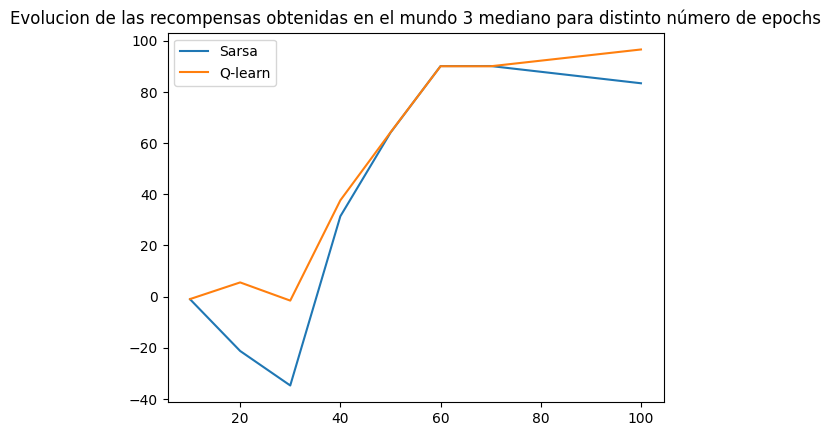

In [ ]:
r = []
for i in [10,20, 30, 40, 50,60, 70, 100]:
  s_p_r = []
  for _ in range(15):#Ya que hay un componente aleatorio se utilizará la media de las recompensas para ese número de epochs
    s_p = sarsa(w3m, [0,0], 0.5, 0.85, 0.1, max_epochs = i)
    s_p_r.append(path_recomp(w3m, s_p, [0,0]))
  r.append(np.array(s_p_r).mean())
plt.plot([10,20, 30, 40, 50,60, 70, 100], r, label = "Sarsa")
plt.title("Evolucion de las recompensas obtenidas en el mundo 3 mediano para distinto número de epochs")


r = []
for i in [10,20, 30, 40, 50,60, 70, 100]:
  q_p_r = []
  for _ in range(15):#Ya que hay un componente aleatorio se utilizará la media de las recompensas para ese número de epochs
    q_p = sarsa(w3m, [0,0], 0.5, 0.85, 0.1, max_epochs = i)
    q_p_r.append(path_recomp(w3m, q_p, [0,0]))
  r.append(np.array(q_p_r).mean())
plt.plot([10,20, 30, 40, 50,60, 70, 100], r, label = "Q-learn")
plt.legend()
plt.show()

## Ejercicio 3 respuestas:

Analizad los resultados obtenidos por ambos algoritmos en los escenarios de prueba. Algunos posibles análisis se muestran a continuación, no es necesario que hagáis todos.

1.   Comentad el rendimiento que observáis en ambos algoritmos. ¿Qué problemas son capaces de resolver? ¿En cuáles no encuentran la solución óptima? ¿A qué se puede deber este comportamiento?


Al implementar todos los algoritmos se han hecho varias modificaciones al código base, obligando al agente a no poder meterse en obstáculos y rebotar en ellos, también modificando las recompensas, se da un refuerzo de 100 por llegar a la meta, -1 por chocar con un obstáculo o salirse del mapa, -0.2 por avanzar a una casilla libre o utilizar un teletransporte.

Al probarlos con todos los mapas disponibles se ha visto que se han resuelto todos los laberintos disponibles salvo el mundo 1 versión grande, esto puede ser porque aunque sea simple la resolución la exploración es más costosa así que aun aumentando el número de épocas y de iteraciones del algoritmo no se consigue encontrar un óptimo.


Además como se puede ver en las gráficas de comparación de obtención de recompensas para los distintos algoritmos, se puede obserevar que Q-learn crece antes que Sarsa. Esto nos demuestra que Q-learn con un menor número de épocas tiende a encontrar el óptimo de forma más rápida que sarsa.


2.   Comentad las diferencias entre los algoritmos en los diferentes escenarios: ¿Cuál resuelve más escenarios? ¿Cuál converge más rápido? ¿Cuál genera más valor?


En general Q-learn resuelve todos los mapas (salvo el mencionado antes). Para los mapas que se consiguen resolver con ambos algoritmos se suele obtener el mismo valor de refuerzo o qlearn consigue un valor ligeramente mayor.


Nota: Las siguientes variables pueden ser interesantes para valorar los resultados: Diferencia entre la política resultante y la política óptima, número de iteraciones necesarias para converger, retorno total del problema y retorno obtenido en cada episodio.

3.   Comentad las diferencias cuando se aplica una mayor exploración ($\epsilon$ más alto) y una mayor explotación ($\epsilon$ más bajo). ¿Cuál converge más rápido? ¿Cuál obtiene más valor? ¿Qué estrategia piensas que podría usarse para explorar y explotar de forma más inteligente?

Converge más rápido si hay un epsilon relativamente bajo (alrededor de 0.1), por lo tanto la estrategia sería explorar un 10% de las veces y explotar el 90% restante.



4.   Comentad las diferencias cuando se varían otros parámetros como el número de episodios, el ratio de aprendizaje ($\alpha$) o el factor de descuento ($\gamma$). ¿Qué valores dan mejores resultados?

Variando el número de epochs se ve que obviamente si tienes más etapas para el entrenamiento entonces el algoritmo sí que puede llegar a converger, para algunos mapas es incluso necesario esto para que pueda llegar al final.

Cambiando alpha y gamma en algunos mapas se ha visto que depende del propio mapa que se esté utilizando, normalmente suele ser mejor no tener un alpha muy pequeño ya que se necesitarán entonces un mayor número de etapas para que se entrene. Alredor de 0.7 suele dar buenos resultados. Para los mapas más fáciles con un alpha de 0.9 se obtienen resultados satisfactorios de forma rápida. El gamma en cambio suele dar mejores resultados cuando toma valores cercanos a 0.85

